In [ ]:
import pandas as pd
import numpy as np
import json
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re, string, unicodedata
import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
!pip install ekphrasis
!pip install tweet-preprocessor
import preprocessor as p
import re
from textblob import TextBlob
import seaborn as sns

!pip install textblob
!python -m textblob.download_corpora

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_recall_curve, accuracy_score
from sklearn.metrics import precision_score, recall_score,f1_score
from sklearn.metrics import roc_auc_score, roc_curve

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
!pip install livelossplot 
from livelossplot import PlotLossesKeras
import tensorflow as tf

%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 81kB 2.7MB/s 
     |████████████████████████████████| 184kB 13.1MB/s 
     |████████████████████████████████| 71kB 4.2MB/s 
  Created wheel for ekphrasis: filename=ekphrasis-0.5.1-cp37-none-any.whl size=82844 sha256=8ce7747de80e6c42bfcab5fec30dd5cbfcd3ad413c99e272b028a95bbc0ef2ee
  Stored in directory: /root/.cache/pip/wheels/2f/c5/9b/c9b60f535a2cf9fdbc92d84c4801a010c35a9cd348011ed2a1
  Created wheel for ftfy: filename=ftfy-6.0.3-cp37-none-any.whl size=41935 sha256=f28b466ff4f1b2f8ffc91513fb7df8bf0e5bffcb6b8ff62b9519bd43544c91b9
  Stored in directory: /root/.cache/pip/wheels/99/2c/e6/109c8a28fef7a443f67ba58df21fe1d0067ac3322e75e6b0b7
Successfully built ekphrasis ftfy
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tweets = pd.read_csv('/content/drive/MyDrive/Rumor Detection/new Dataset/reaction2.csv')
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98929 entries, 0 to 98928
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweetId         98929 non-null  int64 
 1   text            98929 non-null  object
 2   retweet_count   98929 non-null  int64 
 3   favorite_count  98929 non-null  int64 
 4   label           98929 non-null  object
dtypes: int64(3), object(2)
memory usage: 3.8+ MB


In [ ]:
tweets['tweetId'] = tweets['tweetId'].astype(np.int64)
len(tweets['tweetId'].unique())

5748

In [ ]:
tweets['hashtag'] = tweets['text'].apply(lambda x: re.findall(r"#(\w+)", x))

for i,v in enumerate(tweets['text']):
  tweets.loc[i,'text'] = p.clean(v)

def preprocess_data(data):
 #Removes Numbers
 data = data.astype(str).str.replace('\d+', '')
 lower_text = data.str.lower()
 lemmatizer = nltk.stem.WordNetLemmatizer()
 w_tokenizer =  TweetTokenizer()
 
 def lemmatize_text(text):
  return [(lemmatizer.lemmatize(w)) for w \
                       in w_tokenizer.tokenize((text))]

 def remove_punctuation(words):
    new_words = []
    for word in words:
      new_word = re.sub(r'[^\w\s]', '', (word))
      if new_word != '':
        new_words.append(new_word)
    return new_words

 words = lower_text.apply(lemmatize_text)
 words = words.apply(remove_punctuation)
 return pd.DataFrame(words)

pre_tweets = preprocess_data(tweets['text'])
tweets['text'] = pre_tweets
stop_words = set(stopwords.words('english'))
tweets['text'] = tweets['text'].apply(lambda x: [item for item in \
                                    x if item not in stop_words])

In [ ]:
def analyze_sentiment(tweet):
  analysis = TextBlob(tweet)
  return analysis.sentiment.polarity


In [ ]:
tweets['sentiments'] = tweets['text'].apply(lambda x : analyze_sentiment(' '.join(x)))
tweets['n_hashtag'] = tweets['hashtag'].apply(len)
tweets = tweets.drop('hashtag', axis=1)

KeyError: ignored

In [ ]:
tweets.head()

,tweetId,text,retweet_count,favorite_count,label,sentiments,n_hashtag
0,552784600502915072,"[dead, shooting, today, rt, charlie, hebdo, be...",0,0,non-rumours,-0.200000,0
1,552784600502915072,"[im, guessing, considered, terrorism, right, l...",0,0,non-rumours,0.285714,0
2,552784600502915072,"[would, mention, knowing, fact]",1,0,non-rumours,0.000000,1
3,552784600502915072,"[perps, identified]",0,0,non-rumours,0.000000,0
4,552784600502915072,"[charlie, hebdo]",0,0,non-rumours,0.000000,0


In [ ]:
tweets.to_csv('/content/drive/MyDrive/Rumor Detection/new Dataset/clean_reaction.csv')

# Loding clean reactions

In [ ]:
tweets = pd.read_csv('/content/drive/MyDrive/Rumor Detection/new Dataset/claen_reaction.csv').drop('Unnamed: 0', axis=1)
tweets.head()

,tweetId,text,retweet_count,favorite_count,label,sentiments,n_hashtag
0,5527846005029,"['dead', 'shooting', 'today', 'rt', 'charlie',...",0,0,non-rumours,-0.200000,0
1,5527846005029,"['im', 'guessing', 'considered', 'terrorism', ...",0,0,non-rumours,0.285714,0
2,5527846005029,"['would', 'mention', 'knowing', 'fact']",1,0,non-rumours,0.000000,1
3,5527846005029,"['perps', 'identified']",0,0,non-rumours,0.000000,0
4,5527846005029,"['charlie', 'hebdo']",0,0,non-rumours,0.000000,0


In [ ]:
tweets[tweets['tweetId']==4982501000793][['retweet_count', 'favorite_count', 'sentiments', 'n_hashtag']].mean()

retweet_count     0.25
favorite_count    0.75
sentiments        0.00
n_hashtag         0.00
dtype: float64

In [ ]:
def weighted_sentiments_avg(tweet, df, weight_col, colname):
  tweet[colname+"_weighted_polarity"] = tweet['sentiments']*weight_col
  x  = pd.DataFrame(tweet.groupby('tweetId')[colname+"_weighted_polarity"].mean())
  print(x.head())
  # df = df.merge(x, left_index=True, right_index=True)
  return x

In [ ]:
labels = pd.DataFrame(columns=['tweetId', 'label'])

for id in tweets['tweetId'].unique():
  label = tweets[tweets['tweetId'] == id]['label'].unique()[0]
  labels.loc[len(labels.index)] = [id, label]

labels = labels.set_index('tweetId')
labels.head()

,label
tweetId,
5527846005029,non-rumours
5527848987430,non-rumours
5527853916534,non-rumours
5527861164040,non-rumours
5527862998755,non-rumours


In [ ]:
avg = tweets.groupby('tweetId').mean()
df = pd.DataFrame(avg)

df = df.merge(labels, left_index=True, right_index=True)

x = weighted_sentiments_avg(tweets.copy(), df, tweets['favorite_count'] , 'favorite')
df = df.merge(x, left_index=True, right_index=True)

x = weighted_sentiments_avg(tweets.copy(), df, tweets['retweet_count'] , 'retweet')
df = df.merge(x, left_index=True, right_index=True)

x = weighted_sentiments_avg(tweets.copy(), df, tweets['retweet_count']+tweets['favorite_count'] , 'favorite_retweet')
df = df.merge(x, left_index=True, right_index=True)

               favorite_weighted_polarity
tweetId                                  
4982355476857                   -0.146825
4982484152232                   -0.046154
4982486486991                    0.285026
4982501000793                    0.000000
4982519409971                    0.189286
               retweet_weighted_polarity
tweetId                                 
4982355476857                  -0.336508
4982484152232                  -0.101923
4982486486991                   1.961735
4982501000793                   0.000000
4982519409971                   4.005357
               favorite_retweet_weighted_polarity
tweetId                                          
4982355476857                           -0.483333
4982484152232                           -0.148077
4982486486991                            2.246760
4982501000793                            0.000000
4982519409971                            4.194643


In [ ]:
df

,retweet_count,favorite_count,sentiments,n_hashtag,label,favorite_weighted_polarity,retweet_weighted_polarity,favorite_retweet_weighted_polarity
tweetId,,,,,,,,
4982355476857,17.214286,9.142857,0.092460,0.428571,non-rumours,-0.146825,-0.336508,-0.483333
4982484152232,0.576923,0.346154,-0.087019,0.461538,non-rumours,-0.046154,-0.101923,-0.148077
4982486486991,13.089286,2.017857,0.047539,0.517857,non-rumours,0.285026,1.961735,2.246760
4982501000793,0.250000,0.750000,0.000000,0.000000,non-rumours,0.000000,0.000000,0.000000
4982519409971,19.250000,1.375000,0.008036,0.375000,non-rumours,0.189286,4.005357,4.194643
...,...,...,...,...,...,...,...,...
5814607209000,0.000000,0.181818,-0.047348,0.045455,rumours,-0.018750,0.000000,-0.018750
5814730882499,0.000000,0.000000,-0.116071,0.000000,rumours,0.000000,0.000000,0.000000
5814790177709,0.050000,0.050000,-0.007396,0.000000,rumours,-0.001250,-0.001250,-0.002500


In [ ]:
df['label'].unique()

array(['non-rumours', 'rumours'], dtype=object)

In [ ]:
df['label'] = df['label'].replace({'non-rumours':False, 'rumours':True})
df['label'] = df['label'].astype(np.int64)
df[['retweet_count', 'favorite_count' ,'favorite_weighted_polarity', 'n_hashtag',
    'sentiments', 'retweet_weighted_polarity', 'favorite_retweet_weighted_polarity'] ] = df[['retweet_count', 'favorite_count' ,'favorite_weighted_polarity', 'n_hashtag',
                                                                         'sentiments', 'retweet_weighted_polarity', 'favorite_retweet_weighted_polarity'] ].astype(np.int64)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5748 entries, 4982355476857 to 5815506677535
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   retweet_count                       5748 non-null   int64
 1   favorite_count                      5748 non-null   int64
 2   sentiments                          5748 non-null   int64
 3   n_hashtag                           5748 non-null   int64
 4   label                               5748 non-null   int64
 5   favorite_weighted_polarity          5748 non-null   int64
 6   retweet_weighted_polarity           5748 non-null   int64
 7   favorite_retweet_weighted_polarity  5748 non-null   int64
dtypes: int64(8)
memory usage: 564.2 KB


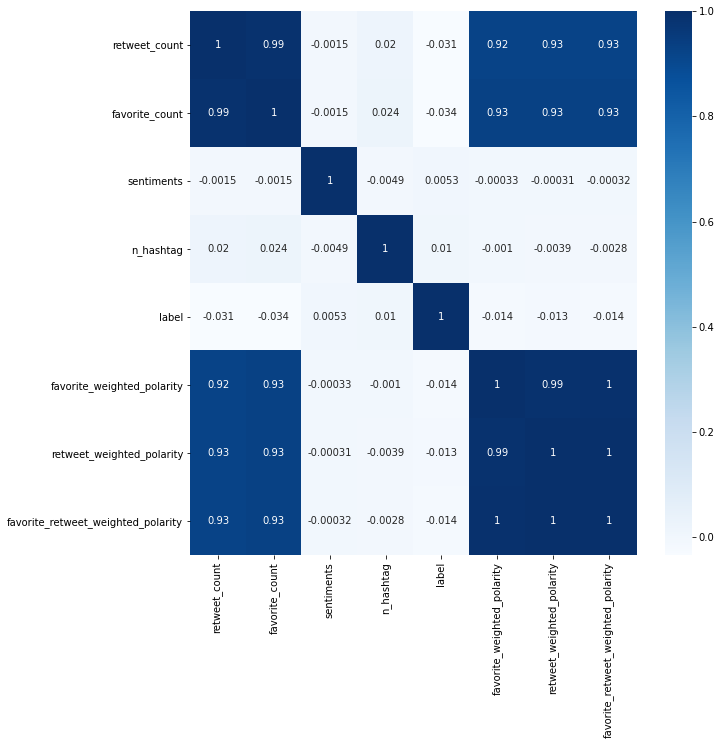

In [ ]:
corr_matrix  = df.corr()
fig = plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot =True, cmap=plt.cm.Blues)

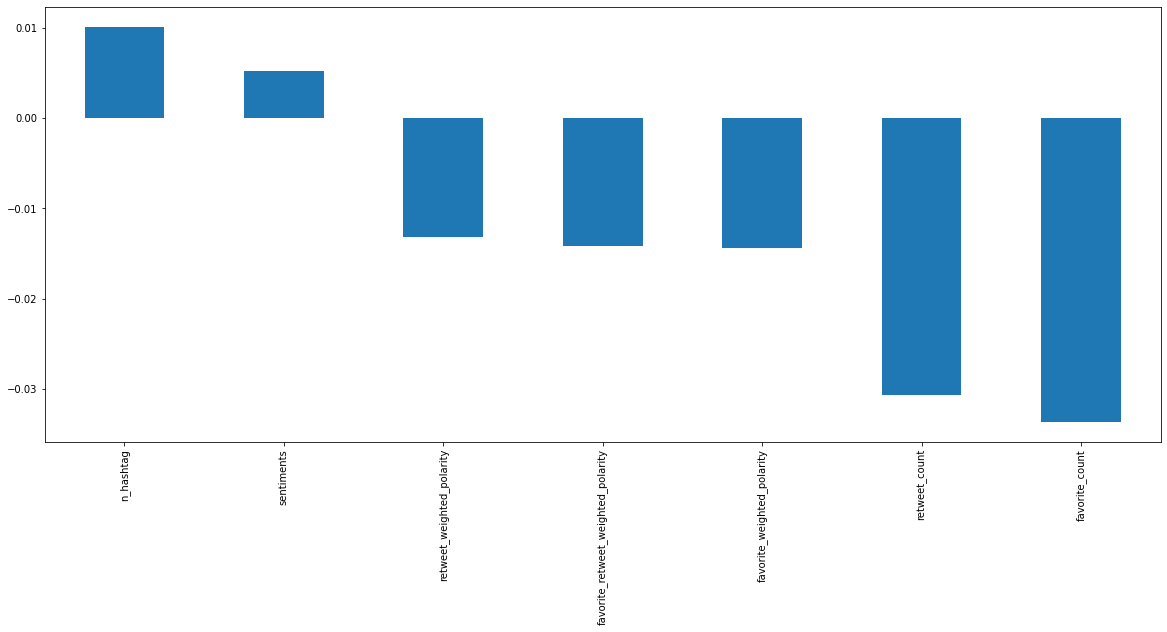

In [ ]:
# Point Biserial  Correlation 
# numerical independent -> dependent binary categorical
from scipy.stats import pointbiserialr

pbc_res = {}
num_features = ['retweet_count', 'favorite_count', 'sentiments', 'n_hashtag',
       'favorite_weighted_polarity', 'retweet_weighted_polarity',
       'favorite_retweet_weighted_polarity']

for col in num_features:
  pbc = pointbiserialr(df[col], df['label'])
  pbc_res[col] = pbc.correlation

pbc = pd.Series(pbc_res)
pbc.sort_values(ascending=False).plot.bar(figsize=(20, 8))

# Models


In [ ]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
sel_features = ['favorite_count', 'sentiments', 'n_hashtag']

X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
metrics = pd.DataFrame(columns=['model' ,'f1 score', 'train accuracy','test accuracy'])
random_state = 42
models=[
        XGBClassifier(max_depth=6, n_estimators=1000),
        LogisticRegression(random_state=random_state),
        SVC(random_state=random_state),
        #MultinomialNB(),
        DecisionTreeClassifier(random_state = random_state),
        KNeighborsClassifier(),
        RandomForestClassifier(random_state=random_state),
       ]

In [ ]:
def fit_and_predict(model,x_train,x_test,y_train,y_test):
    classifier = model
    classifier_name = str(classifier.__class__.__name__)

    classifier.fit(x_train,y_train)

    y_pred = classifier.predict(x_test)
    cmatrix = confusion_matrix(y_test,y_pred)


    f,ax = plt.subplots(figsize=(3,3))
    sns.heatmap(cmatrix,annot=True,linewidths=0.5,cbar=False,linecolor="red",fmt='.0f',ax=ax)
    plt.xlabel("y_predict")
    plt.ylabel("y_true")
    ax.set(title=str(model))
    plt.show()


    f1score = f1_score(y_test,y_pred,average='weighted')
    train_accuracy = round(classifier.score(x_train,y_train)*100)
    test_accuracy =  round(accuracy_score(y_test,y_pred)*100)

    global metrics
    metrics = metrics.append({
                              'model': classifier_name,
                              'f1 score': f1score, 
                              'train accuracy': train_accuracy, 
                              'test accuracy': test_accuracy, 
                             },
                               ignore_index=True
                            )

    print(classification_report(y_test,y_pred))    
    print('Accuracy of classifier on training set:{}%'.format(train_accuracy))
    print('Accuracy of classifier on test set:{}%' .format(test_accuracy))

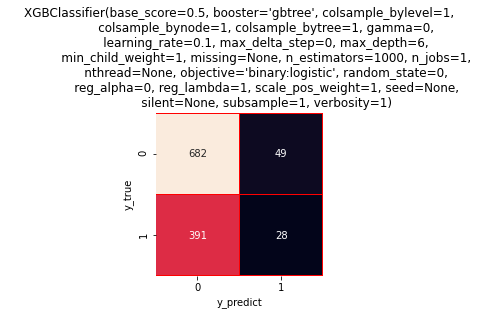

              precision    recall  f1-score   support

           0       0.64      0.93      0.76       731
           1       0.36      0.07      0.11       419

    accuracy                           0.62      1150
   macro avg       0.50      0.50      0.43      1150
weighted avg       0.54      0.62      0.52      1150

Accuracy of classifier on training set:67%
Accuracy of classifier on test set:62%


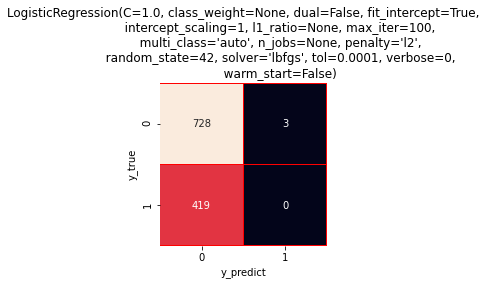

              precision    recall  f1-score   support

           0       0.63      1.00      0.78       731
           1       0.00      0.00      0.00       419

    accuracy                           0.63      1150
   macro avg       0.32      0.50      0.39      1150
weighted avg       0.40      0.63      0.49      1150

Accuracy of classifier on training set:64%
Accuracy of classifier on test set:63%


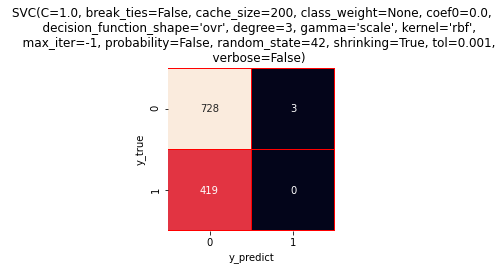

              precision    recall  f1-score   support

           0       0.63      1.00      0.78       731
           1       0.00      0.00      0.00       419

    accuracy                           0.63      1150
   macro avg       0.32      0.50      0.39      1150
weighted avg       0.40      0.63      0.49      1150

Accuracy of classifier on training set:64%
Accuracy of classifier on test set:63%


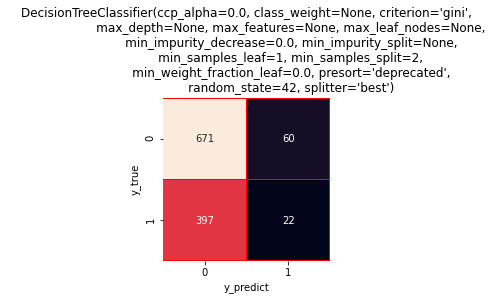

              precision    recall  f1-score   support

           0       0.63      0.92      0.75       731
           1       0.27      0.05      0.09       419

    accuracy                           0.60      1150
   macro avg       0.45      0.49      0.42      1150
weighted avg       0.50      0.60      0.51      1150

Accuracy of classifier on training set:67%
Accuracy of classifier on test set:60%


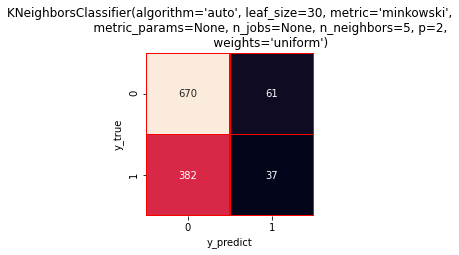

              precision    recall  f1-score   support

           0       0.64      0.92      0.75       731
           1       0.38      0.09      0.14       419

    accuracy                           0.61      1150
   macro avg       0.51      0.50      0.45      1150
weighted avg       0.54      0.61      0.53      1150

Accuracy of classifier on training set:64%
Accuracy of classifier on test set:61%


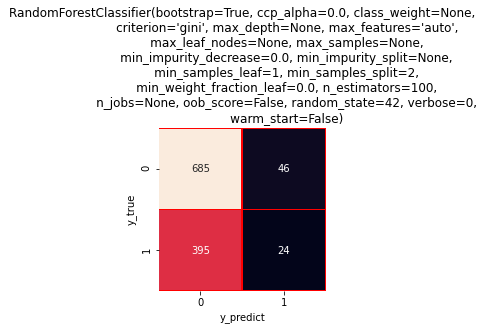

              precision    recall  f1-score   support

           0       0.63      0.94      0.76       731
           1       0.34      0.06      0.10       419

    accuracy                           0.62      1150
   macro avg       0.49      0.50      0.43      1150
weighted avg       0.53      0.62      0.52      1150

Accuracy of classifier on training set:67%
Accuracy of classifier on test set:62%


In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import sklearn.metrics as metric
for model in models:
  fit_and_predict(model,X_train_scaled,X_test_scaled,y_train,y_test)

#neural Network

In [ ]:
model = Sequential([
                          Dense(32, activation='relu', input_shape=X_train.shape),
                          Dropout(0.3),
                          Dense(16, activation='relu'),
                          Dropout(0.2),
                          Dense(16, activation='relu'),
                          Dense(1, activation ='sigmoid')
])

model.build(input_shape = X_train.shape)
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['acc'] )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4598, 32)          256       
_________________________________________________________________
dropout (Dropout)            (None, 4598, 32)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 4598, 16)          528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 4598, 16)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 4598, 16)          272       
_________________________________________________________________
dense_3 (Dense)              (None, 4598, 1)           17        
Total params: 1,073
Trainable params: 1,073
Non-trainable params: 0
______________________________________________________

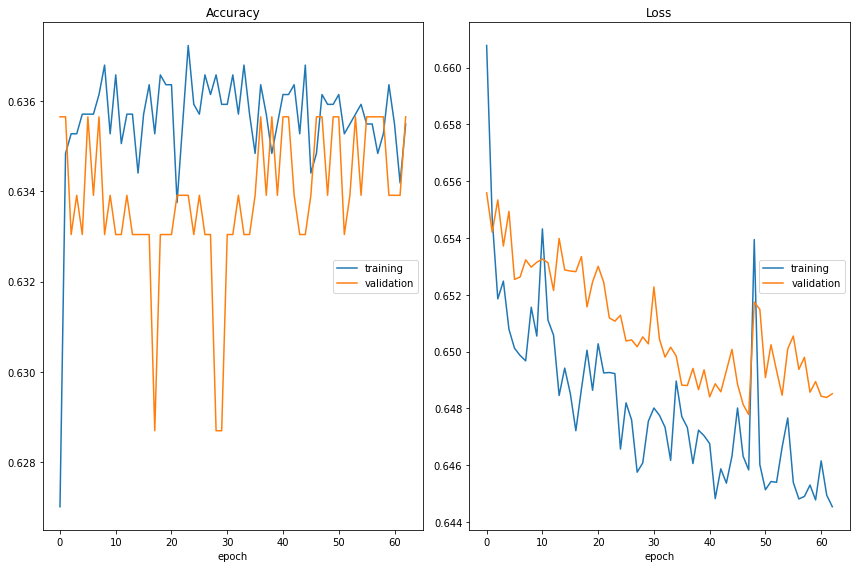

Accuracy
	training         	 (min:    0.627, max:    0.637, cur:    0.635)
	validation       	 (min:    0.629, max:    0.636, cur:    0.636)
Loss
	training         	 (min:    0.645, max:    0.661, cur:    0.645)
	validation       	 (min:    0.648, max:    0.656, cur:    0.649)


In [ ]:

import os
earlyStopping = EarlyStopping(patience=15, mode='min')
# checkpoint = ModelCheckpoint(os.path.join('/content/gdrive/MyDrive/Rumor Detection', 'models', 'reaction_model')
#                               , verbose=1)
callbacks = [ earlyStopping, PlotLossesKeras()]


reaction_model_history = model.fit(X_train_scaled,
                                     y_train,
                                     validation_data=(X_test_scaled, y_test),
                                     epochs=100,
                                     batch_size=16,
                                     verbose=1,
                                     callbacks=callbacks)

In [ ]:
model.save('/content/drive/MyDrive/Rumor Detection/models/all_models/reaction_model.h5')

In [ ]:
def reaction_preprocess(tweets):
  tweets['hashtag'] = tweets['text'].apply(lambda x: re.findall(r"#(\w+)", x))

  for i,v in enumerate(tweets['text']):
    tweets.loc[i,'text'] = p.clean(v)

  def preprocess_data(data):
    #Removes Numbers
    data = data.astype(str).str.replace('\d+', '')
    lower_text = data.str.lower()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    w_tokenizer =  TweetTokenizer()
    
    def lemmatize_text(text):
      return [(lemmatizer.lemmatize(w)) for w \
                          in w_tokenizer.tokenize((text))]

    def remove_punctuation(words):
        new_words = []
        for word in words:
          new_word = re.sub(r'[^\w\s]', '', (word))
          if new_word != '':
            new_words.append(new_word)
        return new_words

    words = lower_text.apply(lemmatize_text)
    words = words.apply(remove_punctuation)
    return pd.DataFrame(words)

  pre_tweets = preprocess_data(tweets['text'])
  tweets['text'] = pre_tweets
  stop_words = set(stopwords.words('english'))
  tweets['text'] = tweets['text'].apply(lambda x: [item for item in \
                                      x if item not in stop_words])

  def analyze_sentiment(tweet):
    analysis = TextBlob(tweet)
    return analysis.sentiment.polarity
  
  tweets['sentiments'] = tweets['text'].apply(lambda x : analyze_sentiment(' '.join(x)))
  tweets['n_hashtag'] = tweets['hashtag'].apply(len)
  tweets = tweets.drop('hashtag', axis=1)

  def weighted_sentiments_avg(tweet, df, weight_col, colname):
    tweet[colname+"_weighted_polarity"] = tweet['sentiments']*weight_col
    x  = pd.DataFrame(tweet.groupby('tweetId')[colname+"_weighted_polarity"].mean())
    print(x.head())
    # df = df.merge(x, left_index=True, right_index=True)
    return x

  labels = pd.DataFrame(columns=['tweetId', 'label'])

  for id in tweets['tweetId'].unique():
    label = tweets[tweets['tweetId'] == id]['label'].unique()[0]
    labels.loc[len(labels.index)] = [id, label]

  avg = tweets.groupby('tweetId').mean()
  df = pd.DataFrame(avg)

  df = df.merge(labels, left_index=True, right_index=True)

  x = weighted_sentiments_avg(tweets.copy(), df, tweets['favorite_count'] , 'favorite')
  df = df.merge(x, left_index=True, right_index=True)

  x = weighted_sentiments_avg(tweets.copy(), df, tweets['retweet_count'] , 'retweet')
  df = df.merge(x, left_index=True, right_index=True)

  x = weighted_sentiments_avg(tweets.copy(), df, tweets['retweet_count']+tweets['favorite_count'] , 'favorite_retweet')
  df = df.merge(x, left_index=True, right_index=True)

  df['label'] = df['label'].replace({'non-rumours':False, 'rumours':True})
  df['label'] = df['label'].astype(np.int64)
  df[['retweet_count', 'favorite_count' ,'favorite_weighted_polarity', 'n_hashtag',
    'sentiments', 'retweet_weighted_polarity', 'favorite_retweet_weighted_polarity'] ] = df[['retweet_count', 'favorite_count' ,'favorite_weighted_polarity', 'n_hashtag',
                                                                         'sentiments', 'retweet_weighted_polarity', 'favorite_retweet_weighted_polarity'] ].astype(np.int64)

  from sklearn.preprocessing import StandardScaler

  scaler = StandardScaler()

  X = scaler.fit_transform(df.drop('label', axis=1))
  y = df['label']

  return X, y